In [1]:
# Import libraries
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
import time
%matplotlib inline

# Set common figure parameters
newparams = {'figure.figsize': (14, 7), 'axes.grid': False,
             'lines.markersize': 6, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
plt.rcParams.update(newparams)

In [2]:
# Definition of helper functions

def RHS(t, y):
    """Calculate the RHS of the EoM, as described above.
    Parameters:
        y: array. Vector of length 24 holding the current position and velocity of the three objects 
           in the following manner: 
           y = [x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4
                vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4].
    Returns:
        z: array. Vector of length 24 holding the derivative of the current position and velocity 
           (the velocity and acceleration) of the three object in the following manner:
           z = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4
                ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4].
    """
    
    # Allocate a vector to hold the output values
    z = np.zeros(24)
    # Define initial velocities and distances between objects
    z[:12] = [y[i] for i in range(12, 24)]
    
    r1, r2, r3, r4 = [y[i: i + 3] for i in range(0, 12, 3)]
    
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)
    r32 = np.linalg.norm(r3 - r2)
    r42 = np.linalg.norm(r4 - r2)
    r43 = np.linalg.norm(r4 - r3)
    
    a1 = G * (m2 * (r2 - r1) / r21 ** 3 + m3 * (r3 - r1) / r31 ** 3 + m4 * (r4 - r1) / r41 ** 3)
    a2 = G * (m1 * (r1 - r2) / r21 ** 3 + m3 * (r3 - r2) / r32 ** 3 + m4 * (r4 - r2) / r42 ** 3)
    a3 = G * (m1 * (r1 - r3) / r31 ** 3 + m2 * (r2 - r3) / r32 ** 3 + m4 * (r4 - r3) / r43 ** 3)
    a4 = G * (m1 * (r1 - r4) / r41 ** 3 + m2 * (r2 - r4) / r42 ** 3 + m3 * (r3 - r4) / r43 ** 3)

    z[12:15] = a1
    z[15:18] = a2
    z[18:21] = a3
    z[21:24] = a4

    return z

def energy(z):
    """Calculate the mechanical energies of the three body system.
    Parameters:
        z: array. Vector of length 24 holding the current position and velocity of the three objects in the
           following manner:
           z = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4
                ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4]
    Returns:
        U: float. The potential energies of the system.
        K: float. The kinetic energies of the system.
    """

    r1, r2, r3, r4 = [z[i: i + 3] for i in range(0, 12, 3)]
    # Pairwise distance between objects
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)
    r32 = np.linalg.norm(r3 - r2)
    r42 = np.linalg.norm(r4 - r2)
    r43 = np.linalg.norm(r4 - r3)
    
    # Calculate potential energies
    # First object is "free", second object is moved from infinity to a distance r21 from the first object.
    # Third object is affected gravitationally by both objects.
    U1 = 0
    U2 = -G * m1 * m2 / r21
    U3 = -G * m1 * m3 / r31 - G * m3 * m2 / r32
    U4 = -G * m4 * m1 / r41 - G * m4 * m2 / r42 - G * m4 * m3 / r43
    U = U1 + U2 + U3 + U4
    
    # Calculate kinetic energies of the three objects
    K1 = 0.5 * m1 * np.linalg.norm(z[12:15]) ** 2
    K2 = 0.5 * m2 * np.linalg.norm(z[15:18]) ** 2
    K3 = 0.5 * m3 * np.linalg.norm(z[18:21]) ** 2
    K4 = 0.5 * m4 * np.linalg.norm(z[21:24]) ** 2
    K = K1 + K2 + K3 + K4
    
    return U, K

def distanceToStars(y):
    """Calculate absolute angular momentum of the three body system.
    Parameters:
        y:          array. Vector of length 24 holding the current position and velocity of the three objects
                    in the following manner: 
                    y = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4
                        ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4].
    Returns:
        r21, r31, r41: array. Distance of the first object(planet) to the other objects(stars).
    """
    r1, r2, r3, r4 = [y[i: i + 3] for i in range(0, 12, 3)]
    # Pairwise distance between objects
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)

    return [r21, r31, r41]

def ode45(f,t,y,h):
    """Calculate next step of an initial value problem (IVP) of an ODE with a RHS described
    by the RHS function with an order 4 approx. and an order 5 approx.
    Parameters:
        t: float. Current time.
        y: float. Current step (position).
        h: float. Step-length.
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    
    s1 = f(t, y)
    s2 = f(t + h / 4.0, y + h * s1 / 4.0)
    s3 = f(t + 3.0 * h / 8.0, y + 3.0 * h * s1 / 32.0 + 9.0 * h * s2 / 32.0)
    s4 = f(t + 12.0 * h / 13.0, y + 1932.0 * h * s1 / 2197.0 - 7200.0 * h * s2 / 2197.0 + 7296.0 * h * s3 / 2197.0)
    s5 = f(t + h, y + 439.0 * h * s1 / 216.0 - 8.0 * h * s2 + 3680.0 * h * s3 / 513.0 - 845.0 * h * s4 / 4104.0)
    s6 = f(t + h / 2.0, y - 8.0 * h * s1 / 27.0 + 2 * h * s2 - 3544.0 * h * s3 / 2565 + 1859.0 * h * s4 / 4104.0 - 11.0 * h * s5 / 40.0)
    w = y + h * (25.0 * s1 / 216.0 + 1408.0 * s3 / 2565.0 + 2197.0 * s4 / 4104.0 - s5 / 5.0)
    q = y + h * (16.0 * s1 / 135.0 + 6656.0 * s3 / 12825.0 + 28561.0 * s4 / 56430.0 - 9.0 * s5 / 50.0 + 2.0 * s6 / 55.0)
    
    return w, q
    
def calc_traj(G, m1, m2, m3, m4, T, TOL, maxi, theta, z0):

    # First step and initial time
    h = T / maxi
    t = 0.

    # Allocate matrices and fill with initial conditions
    Z = np.zeros((24, maxi + 1))
    Z[:, 0] = z0
    E = np.zeros((maxi + 1, 2))
    E[0, :] = energy(z0)
    D = np.zeros((maxi + 1, 3))
    D[0, :] = distanceToStars(z0)

    # Declare iteration integer
    i = 0
    e = 1.
    # Perform ode45 calculations
    tic = time.time()
    while (t < T) & (i < maxi):
        w, q = ode45(RHS, t, Z[:, i], h)
        e = max(abs((w - q) / np.maximum(w, theta)))
        if e > TOL:
            h = 0.95 * (TOL * e) ** (1 / 5) * h 
            w, q = ode45(RHS, t, q, h)
            e = max(abs((w - q) / np.maximum(w, theta)))
            while e > TOL:
                h = h/2.
                w, q = ode45(RHS, t, q, h)
                e = max(abs((w - q) / np.maximum(w, theta)))
        if e < 0.1 * TOL:
            h = h * 2.
        Z[:, i + 1] = q
        E[i + 1, :] = energy(Z[:, i + 1])
        D[i + 1, :] = distanceToStars(Z[:, i + 1])
        t += h
        i += 1

    print("%.5f s, run time of adaptive RK45 method." % (time.time() - tic))
        
    # Print number of steps used
    if (i == maxi):
        print('%i, maximum number of steps reached by adaptive RK45 method.' % i)
    else:
        print('%i, steps used by adaptive RK45 method.' % i)

    return Z, E, D, i

def plot(Z, E, D, i, plot_planet):
    plt.figure()

    # Trajectory
    plt.subplot(2, 2, (1, 2))
    ax = plt.axes(projection="3d")

    if plot_planet:
        plt.plot(Z[0, 0:i], Z[1, 0:i], Z[2, 0:i], '-r', label='Planet')
        ax.scatter3D(Z[0, 0], Z[1, 0], Z[2, 0], marker='*', color='red', label='Init pos Planet')
        
    plt.plot(Z[3, 0:i], Z[4, 0:i], Z[5, 0:i], '-b', label='Star-1')
    plt.plot(Z[6, 0:i], Z[7, 0:i], Z[8, 0:i], '-g', label='Star-2')
    plt.plot(Z[9, 0:i], Z[10, 0:i], Z[11, 0:i], color='black', label='Star-3')
    ax.scatter3D(Z[3, 0], Z[4, 0], Z[5, 0], marker='*', color='blue', label='Init pos Star-1')
    ax.scatter3D(Z[6, 0], Z[7, 0], Z[8, 0], marker='*', color='green', label='Init pos Star-2')
    ax.scatter3D(Z[9, 0], Z[10, 0], Z[11, 0], marker='*', color='black', label='Init pos Star-3')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='best', prop={'size': 10})
    plt.title('Trajectories')
    plt.show()

    # Mechanical energy
    plt.subplot(2, 2, 3)
    plt.plot(E[0:i, 0], 'g', label='K')
    plt.plot(E[0:i, 1], 'b', label='U')
    plt.plot(E[0:i, 0] + E[0:i ,1], 'm', label='Total energy E')
    plt.ylabel('E')
    plt.legend(loc='best', prop={'size': 10})
    plt.title('Energy and absolute angular momentum')

    # Distance from Stars
    plt.subplot(2, 2, 4)
    plt.plot(D[0:i, 0], 'b', label='Star-1')
    plt.plot(D[0:i, 1], 'g', label='Star-2')
    plt.plot(D[0:i, 2], 'r', label='Star-3')
    plt.xlabel('Steps, i')
    plt.ylabel('Distance from Stars')
    plt.legend(loc='best', prop={'size': 10})
    plt.title('Distance from Stars')
    
    plt.show()

In [43]:
init_conditions = {}

# figure8
v = [-0.93240737, -0.86473146, 0]
r1 = [0., 0., 0.2]
r2 = [0.97000436, -0.24308753, 0.]
r3 = [-0.97000436, 0.24308753, 0.]
r4 = [0., 0., 0.]
v1 = [0., 0., 0.]
v2 = [-0.93240737 * (-0.5), -0.86473146 * (-0.5), 0]
v3 = v2
v4 = v
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["fig8"] = z0

# figure8 with planet
v = [-0.93240737, -0.86473146, 0]
r1 = [-0.33, -0.3, 0.]
r2 = [0.97000436, -0.24308753, 0.]
r3 = [-0.97000436, 0.24308753, 0.]
r4 = [0., 0., 0.]
v1 = [0., 0., 0.]
v2 = [-0.93240737 * (-0.5), -0.86473146 * (-0.5), 0]
v3 = v2
v4 = v
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["fig8-planet"] = z0

# figure8 with planet out of plane
v = [-0.93240737, -0.86473146, 0]
r1 = [0., 0., 0.1]
r2 = [0.97000436, -0.24308753, 0.]
r3 = [-0.97000436, 0.24308753, 0.]
r4 = [0., 0., 0.]
v1 = [0., 0., 0.]
v2 = [-0.93240737 * (-0.5), -0.86473146 * (-0.5), 0]
v3 = v2
v4 = v
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["fig8-planet-z"] = z0

0.82295 s, run time of adaptive RK45 method.
500, maximum number of steps reached by adaptive RK45 method.


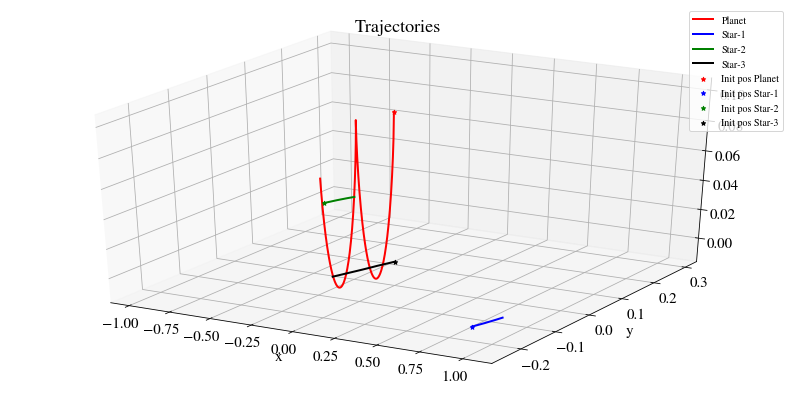

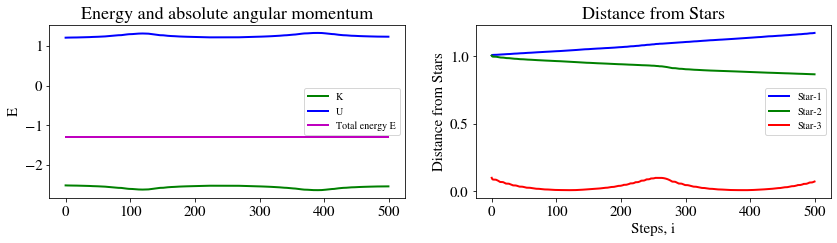

In [44]:
# Set parameters

G = 1.
m1 = 0.001
m2 = 1.
m3 = 1.
m4 = 1.

# Period of calculations
T = 7
# Tolerance
TOL = 0.00001
# Maximum number of steps
maxi = 500
# "Protector-constant" for small w
theta = 0.001

# init conditions
# v = []
# r1 = []
# r2 = []
# r3 = []
# r4 = []
# v1 = []
# v2 = []
# v3 = []
# v4 = []
# z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
z0 = init_conditions['fig8-planet-z']

Z, E, D, i = calc_traj(G, m1, m2, m3, m4, T, TOL, maxi, theta, z0)
plot(Z, E, D, i, plot_planet=True)

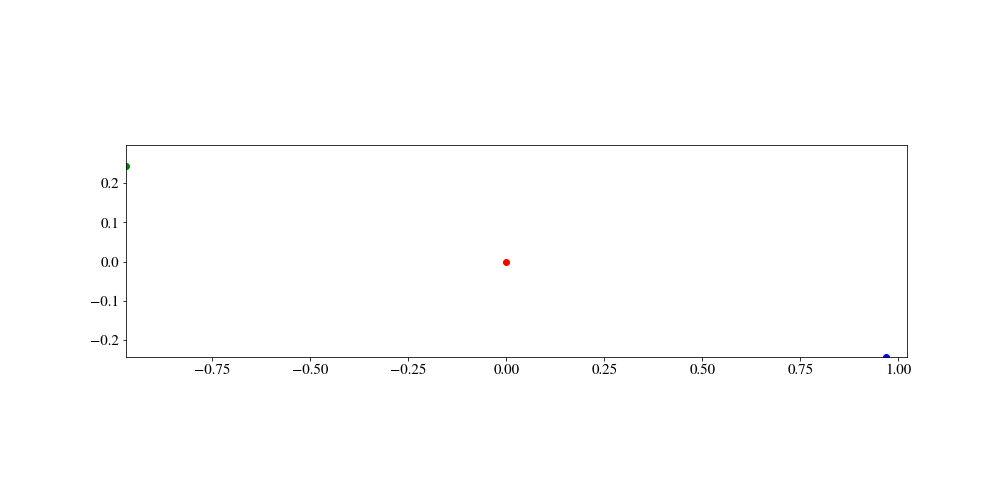

In [46]:
# 2D Animation in x-y plane

# Set up the figure
fig = plt.figure()
ax = plt.axes(xlim=(np.min(Z[[0,3,6,9],:]), np.max(Z[[0,3,6,9],:])), 
              ylim=(np.min(Z[[1,4,7,10],:]), np.max(Z[[1,4,7,10],:])))
ax.set_aspect('equal')

# Define the different elements in the animation
tail1, = ax.plot([],[],'r') # Tail obj. 1
tail2, = ax.plot([],[],'b') # Tail obj. 2
tail3, = ax.plot([],[],'g') # Tail obj. 3
tail4, = ax.plot([],[],color='black') # Tail obj. 4
obj1, = ax.plot([],[],'ro') # Obj. 1
obj2, = ax.plot([],[],'bo') # Obj. 2
obj3, = ax.plot([],[],'go') # Obj. 3
obj4, = ax.plot([],[],color='black') # Obj. 4

# Calculates the number of frames
FPS = 15
framesNum = int(FPS*T)

# Animation function. This is called sequentially.
def animate(j):
    i = j*int(maxi /framesNum)
    obj1.set_data(Z[0,i],Z[1,i])
    obj2.set_data(Z[3,i],Z[4,i])
    obj3.set_data(Z[6,i],Z[7,i])
    obj4.set_data(Z[9,i],Z[10,i])
    tail1.set_data(Z[0,0:i],Z[1,0:i])
    tail2.set_data(Z[3,0:i],Z[4,0:i])
    tail3.set_data(Z[6,0:i],Z[7,0:i])
    tail4.set_data(Z[9,0:i],Z[10,0:i])

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=framesNum)

# Save animation
# If this don't work for you, try using the another writer (ffmpeg, mencoder, imagemagick),
# or another file extension (.mp4, .gif, .ogg, .ogv, .avi etc.). Make sure that you have
# the codec and the writer installed on your system.
anim.save('TrisolarianTrial1.gif', writer='imagemagick', fps=FPS)

# Close plot
plt.close(anim._fig)

# Display the animation
with open('TrisolarianTrial1.gif','rb') as file:
    display(Image(file.read()))


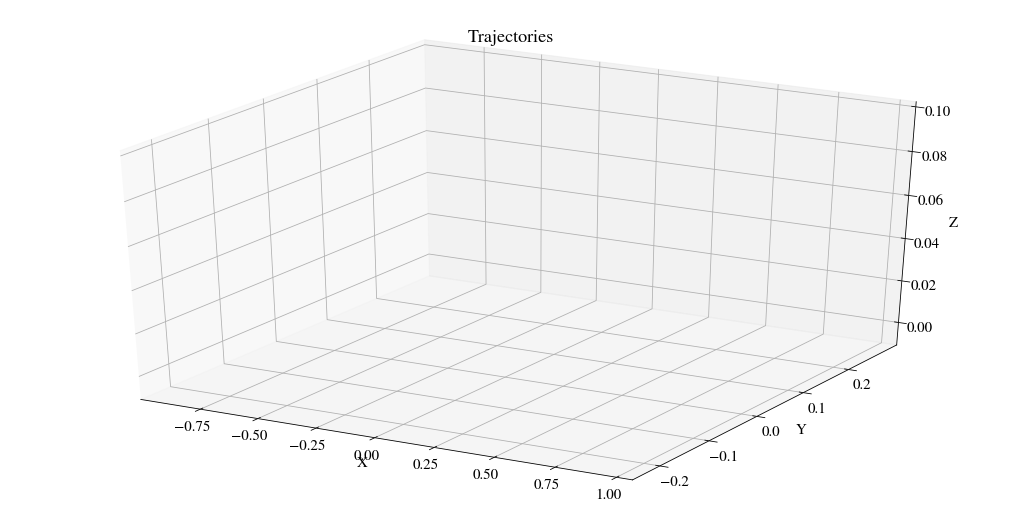

In [45]:
# 3D Animation

from mpl_toolkits.mplot3d import Axes3D
 
# ANIMATION FUNCTION
def func(n, dataSet, obj1, obj2, obj3, obj4):
    i = n * int(maxi /framesNum)
    obj1.set_data(dataSet[0:2, :i])
    obj1.set_3d_properties(dataSet[2, :i])
    obj2.set_data(dataSet[3:5, :i])
    obj2.set_3d_properties(dataSet[5, :i])
    obj3.set_data(dataSet[6:8, :i])
    obj3.set_3d_properties(dataSet[8, :i])
    obj4.set_data(dataSet[9:11, :i])
    obj4.set_3d_properties(dataSet[11, :i])

# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = Axes3D(fig)

# set objects
obj1 = plt.plot(Z[0], Z[1], Z[2], lw=2, c='r')[0]
obj2 = plt.plot(Z[3], Z[4], Z[5], lw=2, c='b')[0]
obj3 = plt.plot(Z[3], Z[4], Z[5], lw=2, c='g')[0]
obj4 = plt.plot(Z[3], Z[4], Z[5], lw=2, c='black')[0]

ax.set_xlim3d([np.min(Z[[0,3,6,9],:]), np.max(Z[[0,3,6,9],:])])
ax.set_ylim3d([np.min(Z[[1,4,7,10],:]), np.max(Z[[1,4,7,10],:])])
ax.set_zlim3d([np.min(Z[[2,5,8,11],:]), np.max(Z[[2,5,8,11],:])])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trajectories')
 
# Creating the Animation object
FPS = 15
framesNum = int(FPS*T)
line_ani = animation.FuncAnimation(fig, func, frames=framesNum, fargs=(Z,obj1,obj2,obj3,obj4), interval=50, blit=False)
line_ani.save('trial.gif', writer='imagemagick', fps=FPS)
 
plt.show()